# Практическое задание №2 

## Общая терминология по используемым данным

Предоставляемые данные для разработки моделей и алгоритмов трекинга мяча в теннисе представляют собор набор игр (game), состоящих из нескольких клипов (clip), каждый из которых состоит из набора кадров (frame). Обратите внимание на структуру организации файлов внутри предоставляемого датасета для полного понимания.

Большинство алгоритмов трекинга объектов работают с несколькими последовательными кадрами, и в данном задании также подразумевается использование этого приема. Последовательность нескольких кадров будем именовать стопкой (stack), размер стопки (stack_s) является гиперпараметром разрабатываемого алгоритма.

# Заготовка решения

## Загрузка датасета
Для работы с данными в ноутбуке kaggle необходимо подключить датасет. File -> Add or upload data, далее в поиске написать tennis-tracking-assignment и выбрать датасет. Если поиск не работает, то можно добавить датасет по url: https://www.kaggle.com/xubiker/tennistrackingassignment. После загрузки данные датасета будут примонтированы в ../input/tennistrackingassignment.

## Установка и импорт зависимостей

Установка необходимых пакетов (не забудьте "включить интернет" в настройках ноутбука kaggle):

In [ ]:
!pip install moviepy --upgrade
!pip install gdown

<font color=red>
После установки пакетов для корректной работы надо обязательно перезагрузить ядро. Run -> Restart and clear cell outputs. Без сего действа будет ошибка при попытке обращения к библиотеке moviepy при сохранении визуализации в виде видео. Может когда-то авторы библиотеки это починят...
</font>

Импорт необходимых зависимостей:

In [ ]:
from pathlib import Path
from typing import List, Tuple, Sequence

import numpy as np
from PIL import Image, ImageDraw, ImageFont
from tqdm import notebook

from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

import math

import gc
import random
import csv

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import gdown

## Набор функций для загрузки данных из датасета

Функция load_clip_data загружает выбранный клип из выбранной игры и возвращает его в виде numpy массива [n_frames, height, width, 3] типа uint8. Для ускорения загрузки используется кэширование - однажды загруженные клипы хранятся на диске в виде npz архивов, при последующем обращении к таким клипам происходит загрузка npz архива.

<font color="red">
Также добавлена возможность чтения клипа в половинном разрешении 640x360, вместо оригинального 1280x720 для упрощения и ускорения разрабатываемых алгоритмов.
</font>

Функция load_clip_labels загружает референсные координаты мяча в клипе в виде numpy массива [n_frames, 4], где в каждой строке массива содержатся значения [code, x, y, q]. x, y соответствуют координате центра мяча на кадре, q не используется в данном задании, code описывает статус мяча:
* code = 0 - мяча в кадре нет
* code = 1 - мяч присутствует в кадре и легко идентифицируем
* code = 2 - мяч присутствует в кадре, но сложно идентифицируем
* code = 3 - мяч присутствует в кадре, но заслонен другими объектами.

При загрузке в половинном разрешении координаты x, y делятся на 2.

Функция load_clip загружает выбранный клип и соответствующий массив координат и возвращает их в виде пары.

In [14]:
def get_num_clips(path: Path, game: int) -> int:
    return len(list((path / f'game{game}/').iterdir()))


def get_game_clip_pairs(path: Path, games: List[int]) -> List[Tuple[int, int]]:
    return [(game, c)  for game in games for c in range(1, get_num_clips(path, game) + 1)]


def load_clip_data(path: Path, game: int, clip: int, downscale: bool, quiet=False) -> np.ndarray:
    if not quiet:
        suffix = 'downscaled' if downscale else ''
        print(f'loading clip data (game {game}, clip {clip}) {suffix}')
    cache_path = path / 'cache'
    cache_path.mkdir(exist_ok=True)
    resize_code = '_ds2' if downscale else ''
    cached_data_name = f'{game}_{clip}{resize_code}.npz'
    if (cache_path / cached_data_name).exists():
        clip_data = np.load(cache_path / cached_data_name)['clip_data']
    else:
        clip_path = path / f'game{game}/clip{clip}'
        n_imgs = len(list(clip_path.iterdir())) - 1
        imgs = [None] * n_imgs
        for i in notebook.tqdm(range(n_imgs)):
            img = Image.open(clip_path / f'{i:04d}.jpg')
            if downscale:
                img = img.resize((img.width // 2, img.height // 2),)
            imgs[i] = np.array(img, dtype=np.uint8)
        clip_data = np.stack(imgs)
        cache_path.mkdir(exist_ok=True, parents=True)
        np.savez_compressed(cache_path / cached_data_name, clip_data=clip_data)
    return clip_data


def load_clip_labels(path: Path, game: int, clip: int, downscale: bool, quiet=False):
    if not quiet:
        print(f'loading clip labels (game {game}, clip {clip})')
    clip_path = path / f'game{game}/clip{clip}'
    labels = []
    with open(clip_path / 'labels.csv') as csvfile:
        lines = list(csv.reader(csvfile))
        for line in lines[1:]:
            values = np.array([-1 if i == '' else int(i) for i in line[1:]])
            if downscale:
                values[1] //= 2
                values[2] //= 2
            labels.append(values)
    return np.stack(labels)


def load_clip(path: Path, game: int, clip: int, downscale: bool, quiet=False):
    data = load_clip_data(path, game, clip, downscale, quiet)
    labels = load_clip_labels(path, game, clip, downscale, quiet)
    return data, labels


## Набор дополнительных функций

Еще несколько функций, немного облегчающих выполнение задания:

* prepare_experiment создает новую директорию в out_path для хранения результатов текущего эксперимента. Нумерация выполняется автоматически, функция возвращает путь к созданной директории эксперимента;
* ball_gauss_template - создает "шаблон" мяча, может быть использована в алгоритмах поиска мяча на изображении по корреляции;
* create_masks - принимает набор кадров и набор координат мяча, и генерирует набор масок, в которых помещает шаблон мяча на заданные координаты. Может быть использована при обучении нейронной сети семантической сегментации;

In [15]:
def prepare_experiment(out_path: Path) -> Path:
    out_path.mkdir(parents=True, exist_ok=True)
    dirs = [d for d in out_path.iterdir() if d.is_dir() and d.name.startswith('exp_')]
    experiment_id = max(int(d.name.split('_')[1]) for d in dirs) + 1 if dirs else 1
    exp_path = out_path / f'exp_{experiment_id}'
    exp_path.mkdir()
    return exp_path


def ball_gauss_template(rad, sigma):
    x, y = np.meshgrid(np.linspace(-rad, rad, 2 * rad + 1), np.linspace(-rad, rad, 2 * rad + 1)) 
    dst = np.sqrt(x * x + y * y) 
    gauss = np.exp(-(dst ** 2 / (2.0 * sigma ** 2)))     
    return gauss


def create_masks(data: np.ndarray, labels: np.ndarray, resize):
    rad = 64 #25
    sigma = 10
    if resize:
        rad //= 2
    ball = ball_gauss_template(rad, sigma)
    n_frames = data.shape[0]
    sh = rad
    masks = []
    for i in range(n_frames):
        label = labels[i, ...] 
        frame = data[i, ...]
        if 0 < label[0] < 3:
            x, y = label[1:3]
            mask = np.zeros((frame.shape[0] + 2 * rad + 2 * sh, frame.shape[1] + 2 * rad + 2 * sh), np.float32)
            mask[y + sh : y + sh + 2 * rad + 1, x + sh : x + sh + 2 * rad + 1] = ball
            mask = mask[rad + sh : -rad - sh, rad + sh : -rad - sh]
            masks.append(mask)
        else:
            masks.append(np.zeros((frame.shape[0], frame.shape[1]), dtype=np.float32))
    return np.stack(masks)


## Набор функций, предназначенных для визуализации результатов

Функция visualize_prediction принимает набор кадров, набор координат детекции мяча (можно подавать как референсные значения, так и предсказанные) и создает видеоклип, в котором отрисовывается положение мяча, его трек, номер кадра и метрика качества трекинга (если она была передана в функцию). Видеоклип сохраняется в виде mp4 файла. Кроме того данная функция создает текстовый файл, в который записывает координаты детекции мяча и значения метрики качества трекинга.

Функция visualize_prob принимает набор кадров и набор предсказанных карт вероятности и создает клип с наложением предсказанных карт вероятности на исходные карты. Области "подсвечиваются" желтым, клип сохраняется в виде mp4 видеофайла. Данная функция может быть полезна при наличии в алгоритме трекинга сети, осуществляющей семантическую сегментацию.

In [16]:
def _add_frame_number(frame: np.ndarray, number: int) -> np.ndarray:
    fnt = ImageFont.load_default() # ImageFont.truetype("arial.ttf", 25)
    img = Image.fromarray(frame)
    draw = ImageDraw.Draw(img)
    draw.text((10, 10), f'frame {number}', font=fnt, fill=(255, 0, 255))
    return np.array(img)


def _vis_clip(data: np.ndarray, lbls: np.ndarray, metrics: List[float] = None, ball_rad=5, color=(255, 0, 0), track_length=10):
    print('perfoming clip visualization')
    n_frames = data.shape[0]
    frames_res = []
    fnt = ImageFont.load_default() # ImageFont.truetype("arial.ttf", 25)
    for i in range(n_frames):
        img = Image.fromarray(data[i, ...])
        draw = ImageDraw.Draw(img)
        txt = f'frame {i}'
        if metrics is not None:
            txt += f', SiBaTrAcc: {metrics[i]:.3f}'
        draw.text((10, 10), txt, font=fnt, fill=(255, 0, 255))
        label = lbls[i]
        if label[0] != 0: # the ball is clearly visible
            px, py = label[1], label[2]
            draw.ellipse((px - ball_rad, py - ball_rad, px + ball_rad, py + ball_rad), outline=color, width=2)
            for q in range(track_length):
                if lbls[i-q-1][0] == 0:
                    break
                if i - q > 0:
                    draw.line((lbls[i - q - 1][1], lbls[i - q - 1][2], lbls[i - q][1], lbls[i - q][2]), fill=color)                
        frames_res.append(np.array(img))
    return frames_res


def _save_clip(frames: Sequence[np.ndarray], path: Path, fps):
    assert path.suffix in ('.mp4', '.gif')
    clip = ImageSequenceClip(frames, fps=fps)
    if path.suffix == '.mp4':
        clip.write_videofile(str(path), fps=fps, logger=None)
    else:
        clip.write_gif(str(path), fps=fps, logger=None)


def _to_yellow_heatmap(frame: np.ndarray, pred_frame: np.ndarray, alpha=0.4):
    img = Image.fromarray((frame * alpha).astype(np.uint8))
    maskR = (pred_frame * (1 - alpha) * 255).astype(np.uint8)
    maskG = (pred_frame * (1 - alpha) * 255).astype(np.uint8)
    maskB = np.zeros_like(maskG, dtype=np.uint8)
    mask = np.stack([maskR, maskG, maskB], axis=-1)
    return img + mask


def _vis_pred_heatmap(data_full: np.ndarray, pred_prob: np.ndarray, display_frame_number):
    n_frames = data_full.shape[0]
    v_frames = []
    for i in range(n_frames):
        frame = data_full[i, ...]
        pred = pred_prob[i, ...]
        hm = _to_yellow_heatmap(frame, pred)
        if display_frame_number:
            hm = _add_frame_number(hm, i)
        v_frames.append(hm)
    return v_frames


def visualize_prediction(data_full: np.ndarray, labels_pr: np.ndarray, save_path: Path, name: str, metrics=None, fps=15):
    with open(save_path / f'{name}.txt', mode='w') as f:
        if metrics is not None:
            f.write(f'SiBaTrAcc: {metrics[-1]} \n')
        for i in range(labels_pr.shape[0]):
            f.write(f'frame {i}: {labels_pr[i, 0]}, {labels_pr[i, 1]}, {labels_pr[i, 2]} \n')

    v = _vis_clip(data_full, labels_pr, metrics)
    _save_clip(v, save_path / f'{name}.mp4', fps=fps)


def visualize_prob(data: np.ndarray, pred_prob: np.ndarray, save_path: Path, name: str, frame_number=True, fps=15):
    v_pred = _vis_pred_heatmap(data, pred_prob, frame_number)
    _save_clip(v_pred, save_path / f'{name}_prob.mp4', fps=fps)


## Класс DataGenerator 

Класс, отвечающий за генерацию данных для обучения модели. Принимает на вход путь к директории с играми, индексы игр, используемые для генерации данных, и размер стопки. Хранит в себе автоматически обновляемый пул с клипами игр.

В пуле содержится pool_s клипов. DataGenerator позволяет генерировать батч из стопок (размера stack_s) последовательных кадров. Выбор клипа для извлечения данных взвешенно-случайный: чем больше длина клипа по сравнению с другими клипами в пуле, тем вероятнее, что именно из него будет сгенерирована стопка кадров. Выбор стопки кадров внтури выбранного клипа полностью случаен. Кадры внутри стопки конкатенируются по последнему измерению (каналам).

После генерирования количества кадров равного общему количеству кадров, хранимых в пуле, происходит автоматическое обновление пула: из пула извлекаются pool_update_s случайных клипов, после чего в пул загружается pool_update_s случайных клипов, не присутствующих в пуле. В случае, если размер пула pool_s больше или равен суммарному количеству клипов в играх, переданных в конструктор, все клипы сразу загружаются в пул, и автообновление не производится.

Использование подобного пула позволяет работать с практически произвольным количеством клипов, без необходимости загружать их всех в оперативную память.

Для вашего удобства функция извлечения стопки кадров из пула помимо самой стопки также создает и возвращает набор сгенерированных масок с мячом исходя из референсных координат мяча в клипе.

Функция random_g принимает гиперпараметр размера стопки кадров и предоставляет генератор, возвращающий стопки кадров и соответствующие им маски. Данный генератор может быть использован при реализации решения на tensorflow. Обновление пула происходит автоматически, об этом беспокоиться не нужно.

In [17]:
class DataGenerator:

    def __init__(self, path: Path, games: List[int], stack_s, downscale, pool_s=30, pool_update_s=10, pool_autoupdate=True, quiet=False) -> None:
        self.path = path
        self.stack_s = stack_s
        self.downscale = downscale
        self.pool_size = pool_s
        self.pool_update_size = pool_update_s
        self.pool_autoupdate = pool_autoupdate
        self.quiet = quiet
        self.data = []
        self.masks = []

        self.frames_in_pool = 0
        self.produced_frames = 0
        self.game_clip_pairs = get_game_clip_pairs(path, list(set(games)))
        self.game_clip_pairs_loaded = []
        self.game_clip_pairs_not_loaded = list.copy(self.game_clip_pairs) 
        self.pool = {}

        self._first_load()

    def _first_load(self):
        # --- if all clips can be placed into pool at once, there is no need to refresh pool at all ---
        if len(self.game_clip_pairs) <= self.pool_size:
            for gcp in self.game_clip_pairs:
                self._load(gcp)
            self.game_clip_pairs_loaded = list.copy(self.game_clip_pairs)
            self.game_clip_pairs_not_loaded.clear()
            self.pool_autoupdate = False
        else:
            self._load_to_pool(self.pool_size)        
        self._update_clip_weights()

    def _load(self, game_clip_pair):
        game, clip = game_clip_pair
        data, labels = load_clip(self.path, game, clip, self.downscale, quiet=self.quiet)
        masks = create_masks(data, labels, self.downscale)
        weight = data.shape[0] if data.shape[0] >= self.stack_s else 0
        self.pool[game_clip_pair] = (data, labels, masks, weight)
        self.frames_in_pool += data.shape[0] - self.stack_s + 1
        # print(f'items in pool: {len(self.pool)} - {self.pool.keys()}')

    def _remove(self, game_clip_pair):
        value = self.pool.pop(game_clip_pair)
        self.frames_in_pool -= value[0].shape[0] - self.stack_s + 1
        del value
        # print(f'items in pool: {len(self.pool)} - {self.pool.keys()}')

    def _update_clip_weights(self):
        weights = [self.pool[pair][-1] for pair in self.game_clip_pairs_loaded]
        tw = sum(weights)
        self.clip_weights = [w / tw for w in weights]
        # print(f'clip weights: {self.clip_weights}')

    def _remove_from_pool(self, n):
        # --- remove n random clips from pool ---
        if len(self.game_clip_pairs_loaded) >= n:
            remove_pairs = random.sample(self.game_clip_pairs_loaded, n)
            for pair in remove_pairs:
                self._remove(pair)
                self.game_clip_pairs_loaded.remove(pair)
                self.game_clip_pairs_not_loaded.append(pair)
            gc.collect()

    def _load_to_pool(self, n):
        # --- add n random clips to pool ---
        gc.collect()
        add_pairs = random.sample(self.game_clip_pairs_not_loaded, n)
        for pair in add_pairs:
            self._load(pair)
            self.game_clip_pairs_not_loaded.remove(pair)
            self.game_clip_pairs_loaded.append(pair)

    def update_pool(self):
        self._remove_from_pool(self.pool_update_size)
        self._load_to_pool(self.pool_update_size)
        self._update_clip_weights()

    def get_random_stack(self):
        pair_idx = np.random.choice(len(self.game_clip_pairs_loaded), 1, p=self.clip_weights)[0]
        game_clip_pair = self.game_clip_pairs_loaded[pair_idx]
        d, _, m, _ = self.pool[game_clip_pair]
        start = np.random.choice(d.shape[0] - self.stack_s, 1)[0]
        frames_stack = d[start : start + self.stack_s, ...]
        frames_stack = np.squeeze(np.split(frames_stack, indices_or_sections=self.stack_s, axis=0))
        frames_stack = np.concatenate(frames_stack, axis=-1)
        mask = m[start + self.stack_s - 1, ...]
        return frames_stack, mask

    def get_random_batch(self, batch_s):
        imgs, masks = [], []
        while len(imgs) < batch_s:
            frames_stack, mask = self.get_random_stack()
            imgs.append(frames_stack)
            masks.append(mask)
        if self.pool_autoupdate:
            self.produced_frames += batch_s
            # print(f'produced frames: {self.produced_frames} from {self.frames_in_pool}')
            if self.produced_frames >= self.frames_in_pool:
                self.update_pool()
                self.produced_frames = 0
        return np.stack(imgs), np.stack(masks)

    def random_g(self, batch_s):
        while True:
            imgs_batch, masks_batch = self.get_random_batch(batch_s)
            yield imgs_batch, masks_batch


### Пример использования DataGenerator

Рекомендованный размер пула pool_s=10 в случае использования уменьшенных вдвое изображений. При большем размере пула есть большая вероятность нехватки имеющихся 13G оперативной памяти.
Используйте параметр quiet=True в конструкторе DataGenerator, если хотите скрыть все сообщения о чтении данных и обновлении пула.

In [18]:
stack_s = 3
batch_s = 4
train_gen = DataGenerator(Path('../input/tennistrackingassignment/train/'), [1, 2, 3, 4], stack_s=stack_s, downscale=True, pool_s=10, pool_update_s=4, quiet=False)
for i in range(10):
    imgs, masks = train_gen.get_random_batch(batch_s)
    print(imgs.shape, imgs.dtype, masks.shape, masks.dtype)
    

loading clip data (game 1, clip 8) downscaled
loading clip labels (game 1, clip 8)
loading clip data (game 4, clip 2) downscaled
loading clip labels (game 4, clip 2)
loading clip data (game 4, clip 7) downscaled
loading clip labels (game 4, clip 7)
loading clip data (game 4, clip 10) downscaled
loading clip labels (game 4, clip 10)
loading clip data (game 2, clip 3) downscaled
loading clip labels (game 2, clip 3)
loading clip data (game 4, clip 15) downscaled
loading clip labels (game 4, clip 15)
loading clip data (game 2, clip 8) downscaled
loading clip labels (game 2, clip 8)
loading clip data (game 4, clip 5) downscaled
loading clip labels (game 4, clip 5)
loading clip data (game 1, clip 9) downscaled
loading clip labels (game 1, clip 9)
loading clip data (game 4, clip 1) downscaled
loading clip labels (game 4, clip 1)
(4, 360, 640, 9) uint8 (4, 360, 640) float32
(4, 360, 640, 9) uint8 (4, 360, 640) float32
(4, 360, 640, 9) uint8 (4, 360, 640) float32
(4, 360, 640, 9) uint8 (4, 360,

loading clip data (game 1, clip 7) downscaled
loading clip labels (game 1, clip 7)
loading clip data (game 1, clip 2) downscaled
loading clip labels (game 1, clip 2)
loading clip data (game 1, clip 5) downscaled
loading clip labels (game 1, clip 5)
loading clip data (game 1, clip 6) downscaled
loading clip labels (game 1, clip 6)
loading clip data (game 1, clip 11) downscaled
loading clip labels (game 1, clip 11)
loading clip data (game 1, clip 12) downscaled
loading clip labels (game 1, clip 12)
loading clip data (game 1, clip 10) downscaled
loading clip labels (game 1, clip 10)
loading clip data (game 1, clip 4) downscaled
loading clip labels (game 1, clip 4)
loading clip data (game 1, clip 13) downscaled
loading clip labels (game 1, clip 13)
loading clip data (game 1, clip 3) downscaled
loading clip labels (game 1, clip 3)
(360, 640, 9) (360, 640)


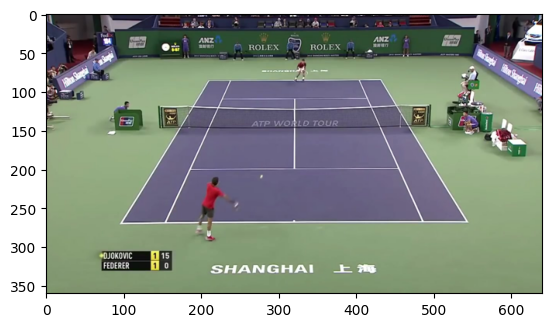

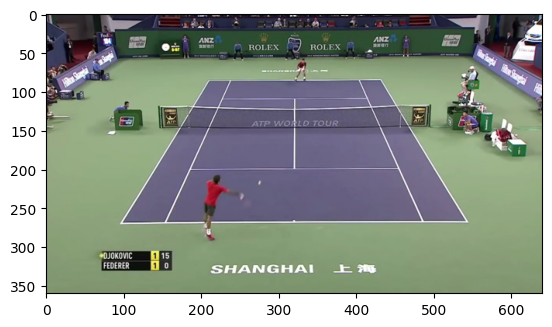

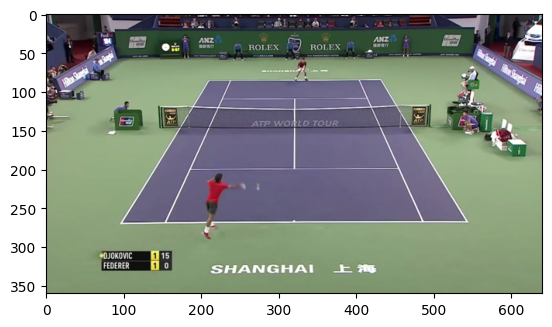

In [20]:
import matplotlib.pyplot as plt

stack_s = 3
train_gen = DataGenerator(Path('../input/tennistrackingassignment/train/'), [1], stack_s=stack_s, downscale=True, pool_s=10, pool_update_s=4, quiet=False)
stack, mask = train_gen.get_random_stack()
print(stack.shape, mask.shape)

for i in range(stack_s):
    plt.figure()
    plt.imshow(stack[:, :, 3 * i: 3 * i + 3])

## Класс Metrics
Класс для вычисления метрики качества трекинга SiBaTrAcc. Функция evaluate_predictions принимает массив из референсных и предсказанных координат мяча для клипа и возвращает массив аккумулированных значений SiBaTrAcc (может быть полезно для визуализации результатов предсказания) и итоговое значение метрики SiBaTrAcc.

In [23]:
class Metrics:

    @staticmethod
    def position_error(label_gt: np.ndarray, label_pr: np.ndarray, step=8, alpha=1.5, e1=5, e2=5):
        # gt codes:
        # 0 - the ball is not within the image
        # 1 - the ball can easily be identified
        # 2 - the ball is in the frame, but is not easy to identify
        # 3 - the ball is occluded
        if label_gt[0] != 0 and label_pr[0] == 0:
            return e1
        if label_gt[0] == 0 and label_pr[0] != 0:
            return e2
        dist = math.sqrt((label_gt[1] - label_pr[1]) ** 2 + (label_gt[2] - label_pr[2]) ** 2)
        pe = math.floor(dist / step) ** alpha
        pe = min(pe, 5)
        return pe

    @staticmethod
    def evaluate_predictions(labels_gt, labels_pr) -> Tuple[List[float], float]:
        pe = [Metrics.position_error(labels_gt[i, ...], labels_pr[i, ...]) for i in range(len(labels_gt))]
        SIBATRACC = []
        for i, _ in enumerate(pe):
            SIBATRACC.append(1 - sum(pe[: i + 1]) / ((i + 1) * 5))
        SIBATRACC_total = 1 - sum(pe) / (len(labels_gt) * 5)
        return SIBATRACC, SIBATRACC_total


## Основной класс модели SuperTrackingModel

Реализует всю логику обучения, сохранения, загрузки и тестирования разработанной модели трекинга. Этот класс можно и нужно расширять.

В качестве примера вам предлагается заготовка модели, в которой трекинг осуществляется за счет предсказания маски по входному батчу и последующему предсказанию координат мяча по полученной маски. В данном варианте вызов функции предсказания координат по клипу (predict) повлечет за собой разбиение клипа на батчи, вызов предсказания маски для каждого батча, склеивание результатов в последовательность масок, вызов функции по вычислению координат мяча по маскам и возвращения результата. Описанные действия уже реализованы, вам остается только написать функции predict_on_bath и get_labels_from_prediction. Эта же функция predict используется и в вызове функции test, дополнительно вычисляя метрику качества трекинга и при необходимости визуализируя результат тестирования. Обратите внимание, что в результирующем numpy массиве с координатами помимо значений x и y первым значением в каждой строке должно идти значение code (0, если мяча в кадре нет и > 0, если мяч в кадре есть) для корректного вычисления качества трекинга.

<font color="red">
Вам разрешается менять логику работы класса модели, (например, если решение не подразумевает использование масок), но при этом логика и работа функций load и test должна остаться неизменной!
</font>

In [24]:
def IoU(y_true, y_pred):
    # Преобразуем входные тензоры в одномерные массивы
    true_flat = K.flatten(y_true)
    pred_flat = K.flatten(y_pred)
    
    # Вычисляем пересечение (совпадающие пиксели)
    intersection = K.sum(true_flat * pred_flat)
    
    # Вычисляем объединение (все пиксели, где хотя бы один из тензоров равен 1)
    union = K.sum(true_flat) + K.sum(pred_flat) - intersection
    
    # Возвращаем коэффициент IoU
    return intersection / union

def IoU_loss(y_true, y_pred):
    # Потери на основе IoU: 1 - IoU
    return 1 - IoU(y_true, y_pred)

In [67]:
from tensorflow.keras.models import load_model
class SuperTrackingModel:
    def __init__(self, batch_size, stack_size, output_path, downscale_factor):
        """
        Initializes the SuperTrackingModel with necessary parameters.

        :param batch_size: Number of samples per batch.
        :param stack_size: Number of frames stacked together for prediction.
        :param output_path: Path where output will be saved.
        :param downscale_factor: Factor by which input frames are downscaled.
        """
        self.batch_size = batch_size
        self.stack_size = stack_size
        self.output_path = output_path
        self.downscale_factor = downscale_factor
        self.model = self.create_unet_model()  # Initialize the U-Net model

    def load_model(self):
        """
        Downloads and loads the pre-trained model weights.
        """
        print('Loading model weights...')
        id = '19164a9zAlKHIJGlmapeC0z_nhI9YNzsM'
        url = f'https://drive.google.com/uc?id={id}'
        output = 'weights.h5'
        gdown.download(url, output, quiet=False)
        # LBL4
        self.model.load_weights("/kaggle/working/weights_best.weights.h5")
        print('Loading model done.')

    def predict_on_batch(self, batch: np.ndarray) -> np.ndarray:
        """
        Makes predictions on a batch of frames.

        :param batch: A batch of frames to predict on.
        :return: The predicted outputs reshaped to match batch size.
        """
        predictions = self.model.predict(batch)
        return predictions.reshape(self.batch_size, 360, 640)

    def _predict_probabilities_on_clip(self, video_clip: np.ndarray) -> np.ndarray:
        """
        Makes predictions on an entire video clip by processing it in batches.

        :param video_clip: The video clip to make predictions on.
        :return: Predicted probabilities for each frame in the clip.
        """
        print('Making predictions...')
        num_frames = video_clip.shape[0]

        # --- Prepare stacks of frames ---
        stacks = self._prepare_stacks(video_clip, num_frames)
        
        # --- Group into batches ---
        batches = self._prepare_batches(stacks)
        
        # --- Make predictions ---
        predictions = self._make_predictions(batches)
        
        # --- Post-process predictions ---
        predictions = self._postprocess_predictions(predictions, stacks)
        print('Predictions are done.')
        
        return predictions

    def _prepare_stacks(self, clip: np.ndarray, num_frames: int) -> List[np.ndarray]:
        """
        Подготавливает стеки кадров для подачи в модель.
    
        :param clip: Видео-клип, из которого создаются стеки.
        :param num_frames: Общее количество кадров в клипе.
        :return: Список стеков, готовых для батчирования.
        """
        stacks = []
        for i in range(num_frames - self.stack_size + 1):
            stack = clip[i:i + self.stack_size, ...]
            stack = np.squeeze(np.split(stack, self.stack_size, axis=0))
            stack = np.concatenate(stack, axis=-1)
            stacks.append(stack)
        return stacks
     
    def _prepare_batches(self, stacks: List[np.ndarray]) -> List[np.ndarray]:
        """
        Groups the prepared stacks into batches.

        :param stacks: List of stacks to group into batches.
        :return: A list of batches for prediction.
        """
        # --- Round to batch size ---
        add_stacks = 0
        while len(stacks) % self.batch_size != 0:
            stacks.append(stacks[-1])  # Duplicate last stack if not divisible by batch_size
            add_stacks += 1
        
        # --- Group into batches ---
        batches = [np.stack(stacks[i * self.batch_size:(i + 1) * self.batch_size]) for i in range(len(stacks) // self.batch_size)]
        return batches


    def _make_predictions(self, batches: List[np.ndarray]) -> List[np.ndarray]:
        """
        Makes predictions on all batches.

        :param batches: List of batches to predict on.
        :return: List of predictions for each batch.
        """
        predictions = [np.squeeze(self.predict_on_batch(batch)) for batch in batches]
        return predictions

    def _postprocess_predictions(self, predictions: List[np.ndarray], stacks: List[np.ndarray]) -> np.ndarray:
        """
        Post-process the predictions, including cropping and adding null frames.

        :param predictions: List of predictions to post-process.
        :param stacks: List of stacks used in prediction.
        :return: The final post-processed predictions.
        """
        predictions = np.concatenate(predictions, axis=0)
        if len(stacks) % self.batch_size != 0:
            predictions = predictions[:-len(stacks) % self.batch_size, ...]
        
        # Add initial null frames
        start_frames = np.zeros((self.stack_size - 1, predictions.shape[1], predictions.shape[2]), dtype=np.float32)
        predictions = np.concatenate((start_frames, predictions), axis=0)
        
        return predictions

    def get_labels_from_prediction(self, predicted_probabilities: np.ndarray, upscale_coords: bool) -> np.ndarray:
        """
        Extracts the ball coordinates from the predicted probabilities.

        :param predicted_probabilities: Predicted probabilities for each frame.
        :param upscale_coords: Whether to upscale coordinates (for downscaled input).
        :return: A numpy array of predicted coordinates with a validity flag.
        """
        num_frames = predicted_probabilities.shape[0]
        coordinates = np.zeros([num_frames, 3])

        for i in range(num_frames):
            mask = predicted_probabilities[i]
            x, y = mask.sum(axis=0).argmax(), mask.sum(axis=1).argmax()
            ball_height, ball_width = mask.sum(axis=0).max(), mask.sum(axis=1).max()
            code = 0 if (ball_height < 5) or (ball_width < 5) else 1
            if upscale_coords:
                x, y = x * 2, y * 2
            coordinates[i] = [code, x, y]
        
        return coordinates

    def postprocess_labels(self, labels: np.ndarray) -> np.ndarray:
        """
        Post-processes the predicted labels, including interpolation and smoothing.

        :param labels: Predicted labels for all frames.
        :return: Post-processed labels.
        """
        indices_x, indices_y = [0], [0]
        x, y = [labels[0][1]], [labels[0][2]]
        
        for i in range(1, len(labels)-1):
            if labels[i][0] == 0 and labels[i-1][0] == 1 and labels[i+1][0] == 1:
                labels[i][0] = 1
            if labels[i][0] == 1:
                if abs(labels[i][1] - labels[i-1][1]) < 50 or abs(labels[i][1] - labels[i+1][1]) < 50:
                    indices_x.append(i)
                    x.append(labels[i][1])
                if abs(labels[i][2] - labels[i-1][2]) < 50 or abs(labels[i][2] - labels[i+1][2]) < 50:
                    indices_y.append(i)
                    y.append(labels[i][2])
        
        indices_x.append(len(labels)-1)
        indices_y.append(len(labels)-1)
        x.append(labels[len(labels)-1][1])
        y.append(labels[len(labels)-1][2])
        
        x = interp1d(indices_x, x)
        y = interp1d(indices_y, y)
        
        indices_x = list(filter(lambda x: x not in indices_x, list(range(len(labels)))))
        indices_y = list(filter(lambda y: y not in indices_y, list(range(len(labels)))))
        
        for i in indices_x:
            labels[i][1] = float(int(x(i)))
        for i in indices_y:
            labels[i][2] = float(int(y(i)))
        
        return labels

    def predict(self, video_clip: np.ndarray, upscale_coords=True) -> np.ndarray:
        """
        Predicts the ball position and probabilities for a video clip.

        :param video_clip: The video clip to make predictions on.
        :param upscale_coords: Whether to upscale coordinates (for downscaled input).
        :return: Post-processed labels and predicted probabilities.
        """
        predicted_probabilities = self._predict_probabilities_on_clip(video_clip)
        predicted_labels = self.get_labels_from_prediction(predicted_probabilities, upscale_coords)
        postprocessed_labels = self.postprocess_labels(predicted_labels)
        return postprocessed_labels, predicted_probabilities

    def test(self, data_path: Path, game_ids: List[int], visualize=False, test_name='test') -> float:
        """
        Evaluates the model on a set of game clips and computes the average SIBATRACC score.

        :param data_path: Path to the data.
        :param game_ids: List of game IDs to evaluate.
        :param visualize: Whether to visualize the predictions.
        :param test_name: Name of the test.
        :return: Average SIBATRACC score.
        """
        # LBL7
        game_clip_pairs = get_game_clip_pairs(data_path, game_ids)
        sibatracc_values = []

        for game, clip in game_clip_pairs:
            clip_data = load_clip_data(data_path, game, clip, downscale=self.downscale_factor)
            
            if visualize:
                full_data = load_clip_data(data_path, game, clip, downscale=False) if self.downscale_factor else clip_data
            
            labels_gt = load_clip_labels(data_path, game, clip, downscale=False)
            predicted_labels, predicted_probabilities = self.predict(clip_data)
            
            sibatracc_frame, sibatracc_total = Metrics.evaluate_predictions(labels_gt, predicted_labels)
            sibatracc_values.append(sibatracc_total)
            
            if visualize:
                visualize_prediction(full_data, predicted_labels, self.output_path, f'{test_name}_g{game}_c{clip}', sibatracc_frame)
                visualize_prob(clip_data, predicted_probabilities, self.output_path, f'{test_name}_g{game}_c{clip}')
                del full_data
            
            del clip_data, labels_gt, predicted_labels, predicted_probabilities
            gc.collect()

        return sum(sibatracc_values) / len(sibatracc_values)

    def create_unet_model(self):
        """
        Creates and returns a U-Net model for frame prediction.

        :return: Compiled Keras U-Net model.
        """
        def double_conv_block(x, num_filters):
            """
            Double convolution block with BatchNormalization.

            :param x: Input tensor.
            :param num_filters: Number of filters for convolutions.
            :return: Output tensor after convolution and BatchNormalization.
            """
            # LBL13
            conv = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
            conv = layers.BatchNormalization()(conv)
            conv = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(1e-4))(conv)
            conv = layers.BatchNormalization()(conv)
            return conv

        def downsample_block(x, num_filters):
            """
            Downsampling block that applies convolution followed by max pooling.

            :param x: Input tensor.
            :param num_filters: Number of filters for convolution.
            :return: Output tensors after convolution and max pooling.
            """
            conv = double_conv_block(x, num_filters)
            pool = layers.MaxPooling2D((2, 2))(conv)
            pool = layers.Dropout(0.3)(pool)
            return conv, pool

        def upsample_block(x, conv, num_filters_transpose, num_filters_conv):
            """
            Upsampling block that applies transpose convolution and concatenates the feature map from the encoder.

            :param x: Input tensor.
            :param conv: Encoder feature map to concatenate.
            :param num_filters_transpose: Number of filters for transpose convolution.
            :param num_filters_conv: Number of filters for convolution.
            :return: Output tensor after upsampling and convolution.
            """
            up = layers.Conv2DTranspose(num_filters_transpose, (3, 3), strides=(2, 2), padding="same")(x)
            up = layers.concatenate([up, conv])
            up = layers.Dropout(0.3)(up)
            conv = double_conv_block(up, num_filters_conv)
            return conv

        inputs = keras.Input(shape=(360, 640, 15))  # Input shape based on stacked frames
        
        # Downsampling blocks
        conv1, pool1 = downsample_block(inputs, 32)
        conv2, pool2 = downsample_block(pool1, 64)
        conv3, pool3 = downsample_block(pool2, 128)
        
        # Bottleneck block
        bottleneck = double_conv_block(pool3, 256)
        
        # Upsampling blocks
        up5 = upsample_block(bottleneck, conv3, 128, 64)
        up6 = upsample_block(up5, conv2, 64, 32)
        up7 = upsample_block(up6, conv1, 32, 16)
        
        # Output layer
        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(up7)

        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=4e-4), loss="binary_crossentropy", metrics=["accuracy"])
        return model

    def train(self, train_data, val_data):
        """
        Trains the model using the given training and validation data.

        :param train_data: Function to load training data.
        :param val_data: Function to load validation data.
        """
        print('Starting model training...')
        #LBL1
        self.model.compile(optimizer=Adam(learning_rate=4e-4), loss=IoU_loss, metrics=[IoU])

        best_model_path = "/kaggle/working/weights_best.weights.h5"
        # LBL3
        model_checkpoint = keras.callbacks.ModelCheckpoint(
            best_model_path, 
            monitor='val_loss', 
            mode='auto', 
            verbose=1, 
            save_best_only=True, 
            save_weights_only=True
        )
        # LBL5
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

        self.history = self.model.fit(
            train_data(self.batch_size),
            steps_per_epoch=150,
            epochs=50,
            callbacks=[model_checkpoint, early_stopping, lr_scheduler],
            validation_data=val_data(self.batch_size),
            validation_steps=50
        )
        print('Training complete.')


In [44]:
output_path = prepare_experiment(Path('/kaggle/working'))

model = SuperTrackingModel(batch_size=4, stack_size=5, output_path=output_path, downscale_factor=True)
model.model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 360, 640, 15)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 360, 640, 32)   │          4,352 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 360, 640, 32)   │            128 │ conv2d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 360, 640, 32)   │          9,248 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 360, 640, 32)   │            128 │ conv2d_31[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 180, 320, 32)   │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 180, 320, 32)   │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 180, 320, 64)   │         18,496 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 180, 320, 64)   │            256 │ conv2d_32[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 180, 320, 64)   │         36,928 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 180, 320, 64)   │            256 │ conv2d_33[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 90, 160, 64)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 90, 160, 64)    │              0 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 90, 160, 128)   │         73,856 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 90, 160, 128)   │            512 │ conv2d_34[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)   

 Total params: 1,763,825 (6.73 MB)

 Trainable params: 1,761,457 (6.72 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [45]:
train_gen = DataGenerator(Path('../input/tennistrackingassignment/train/'), [1, 2, 3, 4, 5, 6], stack_s=stack_s, downscale=True, pool_s=10, pool_update_s=4, quiet=True)
val_gen = DataGenerator(Path('../input/tennistrackingassignment/test/'), [1, 2], stack_s=stack_s, downscale=True, pool_s=4, pool_update_s=2, quiet=True)

In [46]:
model.train(train_gen.random_g, val_gen.random_g)

Starting model training...
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - io_u: 0.0035 - loss: 1.1539
Epoch 1: val_loss improved from inf to 1.03897, saving model to /kaggle/working/weights_best.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 108s 361ms/step - io_u: 0.0035 - loss: 1.1536 - val_io_u: 0.0014 - val_loss: 1.0390 - learning_rate: 4.0000e-04
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - io_u: 0.0087 - loss: 1.0242
Epoch 2: val_loss improved from 1.03897 to 1.00050, saving model to /kaggle/working/weights_best.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 44s 294ms/step - io_u: 0.0087 - loss: 1.0242 - val_io_u: 0.0199 - val_loss: 1.0005 - learning_rate: 4.0000e-04
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - io_u: 0.0244 - loss: 0.9947
Epoch 3: val_loss did not improve from 1.00050
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 287ms/step - io_u: 0.0245 - loss: 0.9947 - val_io_u: 0.0050 - val_loss: 1.0138 - learning_rate: 4.0000e-04
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0

Пример пайплайна для тестирования обученной модели:

In [58]:
import os
print(os.path.exists('/kaggle/working/weights.h5'))

True


In [69]:
batch_s = 4
stack_s = 5
downscale_factor = True
output_path = prepare_experiment(Path('/kaggle/working'))
new_model = SuperTrackingModel(batch_s, stack_s, output_path=output_path, downscale_factor=downscale_factor)
new_model.load_model()
sibatracc_final = new_model.test(Path('../input/tennistrackingassignment/test/'), [1,2], visualize=True, test_name='test')
print(f'SiBaTrAcc final value: {sibatracc_final}')

Loading model weights...


Downloading...
From: https://drive.google.com/uc?id=19164a9zAlKHIJGlmapeC0z_nhI9YNzsM
To: /kaggle/working/weights.h5
100%|██████████| 21.3M/21.3M [00:00<00:00, 92.2MB/s]


Loading model done.
loading clip data (game 1, clip 1) downscaled
loading clip data (game 1, clip 1) 
loading clip labels (game 1, clip 1)
Making predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/

Во время самостоятельного тестирования попробуйте хотя бы раз сделать тестирование с визуализацией (do_visualization=True), чтобы визуально оценить качество трекинга разработанной моделью.

<font color=red>
Загрузка модели через функцию load должна происходить полностью автоматически без каких-либо действий со стороны пользователя! Один из вариантов подобной реализации с использованием google drive и пакета gdown приведен в разделе с дополнениями.
</font>

## Дополнения

Иногда при записи большого количества файлов в output директорию kaggle может "тупить" и не отображать корректно структуру дерева файлов в output и не показывать кнопки для скачивания выбранного файла. В этом случае удобно будет запаковать директорию с экспериментом и выкачать ее вручную. Пример для выкачивания директории с первым экспериментом приведен ниже:

In [72]:
%cd /kaggle/working/
!zip -r "exp.zip" "exp_6"
from IPython.display import FileLink
FileLink(r'exp.zip')

/kaggle/working
  adding: exp_6/ (stored 0%)


/kaggle/working/exp.zip

удалить лишние директории или файлы в output тоже легко:

In [ ]:
!rm -r /kaggle/working/loaded_weights.h5

Для реализации загрузки данных рекомендуется использовать облачное хранилище google drive и пакет gdown для скачивания файлов. Пример подобного использования приведен ниже:
1. загружаем файл в google drive (в данном случае, это npz архив, содержащий один numpy массив по ключу 'w')
2. в интерфейсе google drive открываем доступ на чтение к файлу по ссылке и извлекаем из ссылки id файла
3. формируем url для скачивания файла
4. с помощью gdown скачиваем файл
5. распаковываем npz архив и пользуемся numpy массивом

<font color="red">
Обратите внимание, что для корректной работы нужно правильно определить id файла. В частности, в ссылке https://drive.google.com/file/d/1kZ8CC-zfkB_TlwtBjuPcEfsPV0Jz7IPA/view?usp=sharing id файла заключен между ...d/ b /view?... и равен 1kZ8CC-zfkB_TlwtBjuPcEfsPV0Jz7IPA
</font>

In [ ]:
import gdown

id = '1kZ8CC-zfkB_TlwtBjuPcEfsPV0Jz7IPA'
url = f'https://drive.google.com/uc?id={id}'
output = 'sample-weights.npz'
gdown.download(url, output, quiet=False)

import numpy as np

weights = np.load('/kaggle/working/sample-weights.npz')['w']
print(weights)